In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import linregress

In [2]:
def get_performance_states(results):
    performance_stats=[]
    for split in results["split"].unique():
        tmp = results[results["split"]==split].dropna().copy()
        if len(tmp)<2:continue
        real = tmp["Observed"]
        PR = tmp["Predicted"]
        prsn = pearsonr(np.array(real), np.array(PR))
        sprmn = spearmanr(np.array(real), np.array(PR))
        prsn = prsn[0]
        sprmn = sprmn[0]
        slope = linregress(real,PR)[0]
        r2 = prsn**2
        mae = np.mean(np.abs(np.array(PR) - np.array(real)))
        rMAE = mae / real.mean()
        normMAE = mae / (real.max()-real.min())
        RMSE = np.sqrt(np.mean(np.square(np.array(PR) - np.array(real))))
        rRMSE = RMSE / np.mean(np.array(real))
        normRMSE = RMSE/(real.max()-real.min())
        #based on https://en.wikipedia.org/wiki/Root-mean-square_deviation
        performance_stats.append([split, prsn, sprmn, slope, r2, mae, rMAE, normMAE, RMSE, rRMSE, normRMSE, len(PR)])
    performance_stats = pd.DataFrame(performance_stats, columns=["split", "prsn", "sprmn", "slope", "r2", "mae", "rMAE",
                                                                 "normMAE", "RMSE", "rRMSE", "normRMSE","n"])
    return performance_stats

In [3]:
#import results by fold for use in boxplots
stats_by_set =[]
for mthd_scnrio in [x for x in os.listdir("../data/Results/") if x[:13] == "For_ensamble_"]:
    
    #bring in data for each method
    mthd_scn_data = pd.read_csv("../data/Results/"+mthd_scnrio, index_col=[0])
    mthd_scn_data = mthd_scn_data[mthd_scn_data["set"]=="test"] #use only test set data
    
    #run stats seperatly for each method in files containing multiple methods
    if "method" in mthd_scn_data.columns:
        for GR_method in mthd_scn_data["method"].unique():
            set_stats = get_performance_states(mthd_scn_data[mthd_scn_data["method"]==GR_method])
            set_stats["method_scenario"]=GR_method
            stats_by_set.append(set_stats.copy())
    else:
        set_stats = get_performance_states(mthd_scn_data)
        set_stats["method_scenario"]=mthd_scnrio
        stats_by_set.append(set_stats.copy())

apsim_dir = "../../Washburn_repos/apsim_genotype_calibrator/data/Apsim_files/Classic/Calibrations/Standard_cultivars_pltArea_results/"
for mthd_scnrio in [x for x in os.listdir(apsim_dir) if x[:13] == "For_ensamble_"]:
    #bring in data for each method
    mthd_scn_data = pd.read_csv(apsim_dir+mthd_scnrio, index_col=[0])
    mthd_scn_data = mthd_scn_data[mthd_scn_data["set"]=="test"] #use only test set data
    
    set_stats = get_performance_states(mthd_scn_data)
    set_stats["method_scenario"]=mthd_scnrio
    stats_by_set.append(set_stats.copy())
    
stats_by_set = pd.concat(stats_by_set)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

In [4]:
##split method_scenario column into methods and scenarios
#add extra column with testing scenario
stats_by_set["method_scenario"] = stats_by_set["method_scenario"].str.replace("For_ensamble_","")
stats_by_set["method_scenario"] = stats_by_set["method_scenario"].str.replace(".csv","")
stats_by_set["scenario"] = stats_by_set["method_scenario"].str[-10:]

repl = {'_23Apr2020':"G holdout", '13_Dec2019':"GEM hard", '_13Dec2019':"GEM hard", '_26Feb2020':"GEM Practical", '_24Apr2020':"E holdout"}
for key in repl:
    #print(key)
    stats_by_set["scenario"] = stats_by_set["scenario"].str.replace(key, repl[key])

#NEED TO ADD APSIM

stats_by_set = stats_by_set[stats_by_set["split"] != "S_Historical"]

In [5]:
#create simplified method names for each method
stats_by_set["method"] = stats_by_set["method_scenario"]
method_names = {'APSIM_yield_FlwTm_repsTrain_val_test_sets_13_Dec2019':'CGM FTCal',
'APSIM_yield_FlwTm_repsTrain_val_test_sets_Practical_GEM_26Feb2020':'CGM FTCal',
'APSIM_yield_FlwrTm_repsTrain_val_test_sets_E_dwnSample293_24Apr2020':'CGM FTCal',
'APSIM_yield_FlwrTm_repsTrain_val_test_sets_G_dwnSample12_23Apr2020':'CGM FTCal',

'APSIM_yield_repsTrain_val_test_sets_13_Dec2019':'AUTO CGM1',
'APSIM_yield_repsTrain_val_test_sets_E_dwnSample293_24Apr2020':'AUTO CGM1',
'APSIM_yield_repsTrain_val_test_sets_G_dwnSample12_23Apr2020':'AUTO CGM1',
'APSIM_yield_repsTrain_val_test_sets_Practical_GEM_26Feb2020':'AUTO CGM1',

'E_GR_13_Dec2019':"E BLUP",
'E_GR_E_dwnSample293_24Apr2020':"E BLUP",
'E_GR_G_dwnSample12_23Apr2020':"E BLUP",
'E_GR_Practical_GEM_26Feb2020':"E BLUP",

'G2FonHist_GEM_reps_val_training_13_Dec2019':'CNN G2F on Hist',
'G2FonHist_reps_val_training_E_dwnSample293_24Apr2020':'CNN G2F on Hist',
'G2FonHist_reps_val_training_G_dwnSample12_23Apr2020':'CNN G2F on Hist',
'G2FonHist_reps_val_training_Practical_GEM_26Feb2020':'CNN G2F on Hist',

'GE_GR_13_Dec2019':"GE BLUP",
'GE_GR_E_dwnSample293_24Apr2020':"GE BLUP",
'GE_GR_G_dwnSample12_23Apr2020':"GE BLUP",
'GE_GR_Practical_GEM_26Feb2020':"GE BLUP",
    
'G_GR_13_Dec2019':"G BLUP",
'G_GR_E_dwnSample293_24Apr2020':"G BLUP",
'G_GR_G_dwnSample12_23Apr2020':"G BLUP",
'G_GR_Practical_GEM_26Feb2020':"G BLUP",

'GxE_GR_13_Dec2019':"GxE BLUP",
'GxE_GR_E_dwnSample293_24Apr2020':"GxE BLUP",
'GxE_GR_G_dwnSample12_23Apr2020':"GxE BLUP",
'GxE_GR_Practical_GEM_26Feb2020':"GxE BLUP",

#AD blup called D BLUP
'G-AD_GR_GEM_Hard_13Dec2019':"D BLUP",
'G-AD_GR_E_dwnSample293_24Apr2020':"D BLUP",
'G-AD_GR_G_dwnSample12_23Apr2020':"D BLUP",
'G-AD_GR_Practical_GEM_26Feb2020':"D BLUP",
                
'GE-AD_GR_GEM_Hard_13Dec2019':"DE BLUP",
'GE-AD_GR_E_dwnSample293_24Apr2020':"DE BLUP",
'GE-AD_GR_G_dwnSample12_23Apr2020':"DE BLUP",
'GE-AD_GR_Practical_GEM_26Feb2020':"DE BLUP",

'GxE-AD_GR_GEM_Hard_13Dec2019':"DxE BLUP",
'GxE-AD_GR_E_dwnSample293_24Apr2020':"DxE BLUP",
'GxE-AD_GR_G_dwnSample12_23Apr2020':"DxE BLUP",
'GxE-AD_GR_Practical_GEM_26Feb2020':"DxE BLUP",                
                
#CNN models
'GEM_reps_val_training_13_Dec2019':"CNN",
'reps_val_training_E_dwnSample293_24Apr2020':"CNN",
'reps_val_training_G_dwnSample12_23Apr2020':"CNN",
'reps_val_training_Practical_GEM_26Feb2020':"CNN",

'reps_val_training_MLP_large13_Dec2019':"MLP",
'reps_val_training_MLP_largeE_dwnSample293_24Apr2020':"MLP",
'reps_val_training_MLP_largeG_dwnSample12_23Apr2020':"MLP",
'reps_val_training_MLP_largePractical_GEM_26Feb2020':"MLP",

'reps_val_training_ReluFinalWeathCons_13_Dec2019':"ReluFinalWeathCons",
'reps_val_training_ReluFinalWeathCons_E_dwnSample293_24Apr2020':"ReluFinalWeathCons",
'reps_val_training_ReluFinalWeathCons_G_dwnSample12_23Apr2020':"ReluFinalWeathCons",
'reps_val_training_ReluFinalWeathCons_Practical_GEM_26Feb2020':"ReluFinalWeathCons",
                
'reps_val_training_NO_HIST_13_Dec2019':"CNN NO HIST",
'reps_val_training_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO HIST",
'reps_val_training_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO HIST",
'reps_val_training_NO_HIST_Practical_GEM_26Feb2020':"CNN NO HIST",

'reps_val_training_NO_G_E_dwnSample293_24Apr2020':'CNN NO G',
'reps_val_training_NO_G_G_dwnSample12_23Apr2020':'CNN NO G',
'reps_val_training_NO_G_Practical_GEM_26Feb2020':'CNN NO G',
'reps_val_training_NO_G_13_Dec2019':'CNN NO G',

'reps_val_training_NO_SOIL_13_Dec2019':"CNN NO SOIL",
'reps_val_training_NO_SOIL_E_dwnSample293_24Apr2020':"CNN NO SOIL",
'reps_val_training_NO_SOIL_G_dwnSample12_23Apr2020':"CNN NO SOIL",
'reps_val_training_NO_SOIL_Practical_GEM_26Feb2020':"CNN NO SOIL",
                
'reps_val_training_NO_WEATH_13_Dec2019':"CNN NO WEATH",
'reps_val_training_NO_WEATH_E_dwnSample293_24Apr2020':"CNN NO WEATH",
'reps_val_training_NO_WEATH_G_dwnSample12_23Apr2020':"CNN NO WEATH",
'reps_val_training_NO_WEATH_Practical_GEM_26Feb2020':"CNN NO WEATH",
                
'reps_val_training_NO_G_HIST_E_dwnSample293_24Apr2020':'CNN NO G NO HIST',
'reps_val_training_NO_G_HIST_G_dwnSample12_23Apr2020':'CNN NO G NO HIST',
'reps_val_training_NO_G_HIST_Practical_GEM_26Feb2020':'CNN NO G NO HIST',
'reps_val_training_NO_G_HIST_13_Dec2019':'CNN NO G NO HIST',

'reps_val_training_G_only_13_Dec2019':"CNN G ONLY NO HIST",
'reps_val_training_G_only_E_dwnSample293_24Apr2020':"CNN G ONLY NO HIST",
'reps_val_training_G_only_G_dwnSample12_23Apr2020':"CNN G ONLY NO HIST",
'reps_val_training_G_only_Practical_GEM_26Feb2020':"CNN G ONLY NO HIST",
                
'reps_val_training_SOIL_only_NO_HIST_13_Dec2019':"CNN SOIL ONLY NO HIST",
'reps_val_training_SOIL_only_NO_HIST_E_dwnSample293_24Apr2020':"CNN SOIL ONLY NO HIST",
'reps_val_training_SOIL_only_NO_HIST_G_dwnSample12_23Apr2020':"CNN SOIL ONLY NO HIST",
'reps_val_training_SOIL_only_NO_HIST_Practical_GEM_26Feb2020':"CNN SOIL ONLY NO HIST",
                
'reps_val_training_FERT_only_13_Dec2019':"CNN FERT ONLY NO HIST",
'reps_val_training_FERT_only_E_dwnSample293_24Apr2020':"CNN FERT ONLY NO HIST",
'reps_val_training_FERT_only_G_dwnSample12_23Apr2020':"CNN FERT ONLY NO HIST",
'reps_val_training_FERT_only_Practical_GEM_26Feb2020':"CNN FERT ONLY NO HIST",
                
'reps_val_training_WEATH_only_NO_HIST_13_Dec2019':"CNN WEATH ONLY NO HIST",
'reps_val_training_WEATH_only_NO_HIST_E_dwnSample293_24Apr2020':"CNN WEATH ONLY NO HIST",
'reps_val_training_WEATH_only_NO_HIST_G_dwnSample12_23Apr2020':"CNN WEATH ONLY NO HIST",
'reps_val_training_WEATH_only_NO_HIST_Practical_GEM_26Feb2020':"CNN WEATH ONLY NO HIST",
                
'reps_val_training_NO_SOIL_NO_HIST_13_Dec2019':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO SOIL NO HIST",
'reps_val_training_NO_SOIL_NO_HIST_Practical_GEM_26Feb2020':"CNN NO SOIL NO HIST",
       
'reps_val_training_FIELD_only_NO_HIST_13_Dec2019':"CNN FIELD ONLY NO HIST",
'reps_val_training_FIELD_only_NO_HIST_E_dwnSample293_24Apr2020':"CNN FIELD ONLY NO HIST",
'reps_val_training_FIELD_only_NO_HIST_G_dwnSample12_23Apr2020':"CNN FIELD ONLY NO HIST",
'reps_val_training_FIELD_only_NO_HIST_Practical_GEM_26Feb2020':"CNN FIELD ONLY NO HIST",
                
'reps_val_training_RM_LOWSOIL_13_Dec2019':'CNN RM MISS SOIL',
'reps_val_training_RM_LOWSOIL_E_dwnSample293_24Apr2020':'CNN RM MISS SOIL',
'reps_val_training_RM_LOWSOIL_G_dwnSample12_23Apr2020':'CNN RM MISS SOIL',
'reps_val_training_RM_LOWSOIL_Practical_GEM_26Feb2020':'CNN RM MISS SOIL',

'reps_val_training_NO_GYPS_13_Dec2019':'CNN NO GYPSUM',
'reps_val_training_NO_GYPS_E_dwnSample293_24Apr2020':'CNN NO GYPSUM',
'reps_val_training_NO_GYPS_G_dwnSample12_23Apr2020':'CNN NO GYPSUM',
'reps_val_training_NO_GYPS_Practical_GEM_26Feb2020':'CNN NO GYPSUM',

'reps_val_training_NO_WEATH_NO_HIST_13_Dec2019':"CNN NO WEATH NO HIST",
'reps_val_training_NO_WEATH_NO_HIST_E_dwnSample293_24Apr2020':"CNN NO WEATH NO HIST",
'reps_val_training_NO_WEATH_NO_HIST_G_dwnSample12_23Apr2020':"CNN NO WEATH NO HIST",
'reps_val_training_NO_WEATH_NO_HIST_Practical_GEM_26Feb2020':"CNN NO WEATH NO HIST",
                
'reps_val_training_RM_LOWSOIL_NO_HIST_13_Dec2019':'CNN RM MISS SOIL NO HIST',
'reps_val_training_RM_LOWSOIL_NO_HIST_E_dwnSample293_24Apr2020':'CNN RM MISS SOIL NO HIST',
'reps_val_training_RM_LOWSOIL_NO_HIST_G_dwnSample12_23Apr2020':'CNN RM MISS SOIL NO HIST',
'reps_val_training_RM_LOWSOIL_NO_HIST_Practical_GEM_26Feb2020':'CNN RM MISS SOIL NO HIST',

'reps_val_training_NO_GYPS_NO_HIST_13_Dec2019':'CNN NO GYPSUM NO HIST',
'reps_val_training_NO_GYPS_NO_HIST_E_dwnSample293_24Apr2020':'CNN NO GYPSUM NO HIST',
'reps_val_training_NO_GYPS_NO_HIST_G_dwnSample12_23Apr2020':'CNN NO GYPSUM NO HIST',
'reps_val_training_NO_GYPS_NO_HIST_Practical_GEM_26Feb2020':'CNN NO GYPSUM NO HIST',
               }


In [6]:
for key in method_names.keys():
    #print(key, method_names[key])
    stats_by_set["method"] = stats_by_set["method"].str.replace(key, method_names[key])

#change some names
stats_by_set = stats_by_set.rename(columns={"prsn":"Pearson r", "rRMSE":"Relative RMSE", "normRMSE":"Normalized RMSE"})

In [7]:
pd.set_option('display.max_rows', 300)
#stats_by_set.drop_duplicates(["method_scenario"])#[["method_scenario","scenario","method"]]

In [8]:
def find_rename_best_model(stats_by_set, model1, model2, final_name):
    #make copy of model1 and model2 results results
    GE_GbyE = stats_by_set[stats_by_set["method"].isin([model1, model2])].copy()
    #calculate which method is best, drop lower method, rename method and merge back in
    #GE_GbyE_avg = GE_GbyE.pivot_table(index=["scenario","method"], values="RMSE").sort_values("RMSE").reset_index()
    GE_GbyE_avg = GE_GbyE.pivot_table(index=["scenario","method"], values="Pearson r").sort_values("Pearson r", ascending=False).reset_index()
    GE_GbyE_avg = GE_GbyE_avg.drop_duplicates(subset=["scenario"])
    GE_GbyE = GE_GbyE_avg[["method","scenario"]].merge(GE_GbyE, on=["method","scenario"], how="left")
    GE_GbyE["method"] = GE_GbyE["method"].replace(model2, final_name)
    GE_GbyE["method"] = GE_GbyE["method"].replace(model1, final_name)
    #add back in to stats_by_set
    return pd.concat([stats_by_set, GE_GbyE]).reset_index(drop=True)

In [9]:
#find best APSIM and BEST GE/GxE BLUP method for each scenario
stats_by_set = find_rename_best_model(stats_by_set, "GE BLUP", "GxE BLUP", "GE/GxE BLUP")
stats_by_set = find_rename_best_model(stats_by_set, "DE BLUP", "DxE BLUP", "DE/DxE BLUP")
stats_by_set = find_rename_best_model(stats_by_set, 'CGM FTCal', 'AUTO CGM1', 'AUTO CGM')
stats_by_set = find_rename_best_model(stats_by_set, 'MLP', 'CNN', 'CNN/MLP')

In [10]:
pd.set_option('display.max_rows', 300)
stats_by_set["method"].unique()

array(['CNN NO GYPSUM', 'CNN RM MISS SOIL NO HIST', 'MLP', 'CNN NO HIST',
       'CNN WEATH ONLY NO HIST', 'CNN NO SOIL NO HIST', 'CNN NO WEATH',
       'CNN NO WEATH NO HIST', 'CNN', 'CNN NO SOIL',
       'CNN SOIL ONLY NO HIST', 'CNN G2F on Hist', 'CNN NO G NO HIST',
       'reps_val_training_tanh_final_Practical_GEM_26Feb2020', 'CNN NO G',
       'ReluFinalWeathCons', 'CNN FIELD ONLY NO HIST',
       'CNN G ONLY NO HIST', 'CNN RM MISS SOIL', 'CNN FERT ONLY NO HIST',
       'CNN NO GYPSUM NO HIST', 'G BLUP', 'E BLUP', 'GE BLUP', 'GxE BLUP',
       'D BLUP', 'DE BLUP', 'DxE BLUP',
       'reps_val_training_tanhPractical_GEM_26Feb2020', 'AUTO CGM1',
       'CGM FTCal', 'GE/GxE BLUP', 'DE/DxE BLUP', 'AUTO CGM', 'CNN/MLP'],
      dtype=object)

In [11]:
def creat_box_plot(stats_by_set, scenario, methods_to_plot, stat):
    for_plot = stats_by_set[(stats_by_set["scenario"]==scenario) & (stats_by_set["method"].isin(methods_to_plot))].copy()
    for_plot = for_plot.sort_values(stat).drop_duplicates().reset_index(drop=True)
    #determine order
    col_order = for_plot.pivot_table(index=["scenario","method"], values=stat, aggfunc=np.median
                                    ).reset_index().sort_values(stat)["method"].tolist()
    n = for_plot.pivot_table(index=["scenario","method"], aggfunc=np.count_nonzero, values=stat).reset_index()
    n.index=n["method"]
    n = n.loc[col_order]
    n = n[stat].to_dict()
    
    #ax = sns.catplot(x="method", y=stat, kind="violin", data=for_plot)
    #kwargs = {'axis.edgecolor':"black"}
    #sns.set_style({'axes.edgecolor': 'black', })
    ax = sns.boxplot(x="method", y=stat, order=col_order, data=for_plot)
    #ax = sns.swarmplot(x="method", y=stat, data=for_plot, color=".25")
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('gray')
    ax.set_xlabel("")
    ax.set_ylabel(stat, fontsize=12, color="black")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
        label.set_color("black")
    ax.set_title(scenario)
    ax.set(facecolor = "white")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.setp(ax.artists, edgecolor = 'k', facecolor='gray')
    plt.setp(ax.lines, color='k')
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
    
    #make all have same scale
    plt.ylim(-0.7,1.0)
    #plt.ylim(0,1.0)
    
    plt.show()
    return n

G holdout


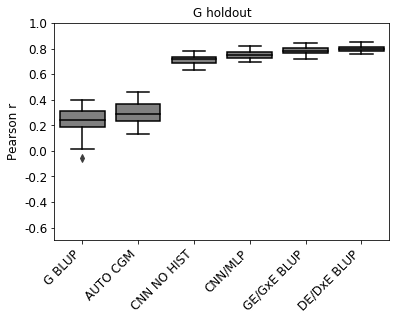

{'G BLUP': 50.0, 'AUTO CGM': 50.0, 'CNN NO HIST': 50.0, 'CNN/MLP': 50.0, 'GE/GxE BLUP': 50.0, 'DE/DxE BLUP': 50.0}
E holdout


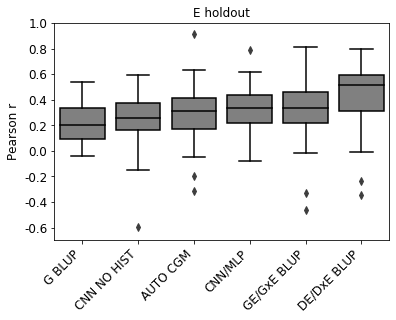

{'G BLUP': 73.0, 'CNN NO HIST': 73.0, 'AUTO CGM': 73.0, 'CNN/MLP': 73.0, 'GE/GxE BLUP': 73.0, 'DE/DxE BLUP': 73.0}
GEM Practical


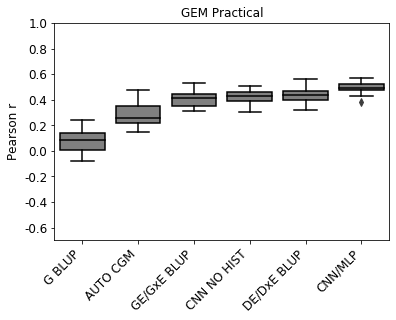

{'G BLUP': 40.0, 'AUTO CGM': 40.0, 'GE/GxE BLUP': 40.0, 'CNN NO HIST': 40.0, 'DE/DxE BLUP': 40.0, 'CNN/MLP': 40.0}
GEM hard


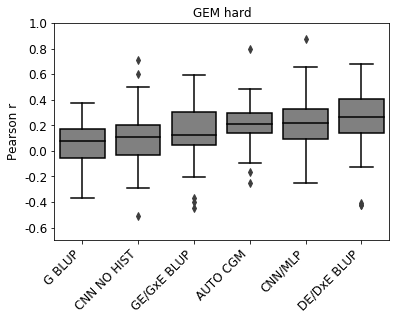

{'G BLUP': 49.0, 'CNN NO HIST': 49.0, 'GE/GxE BLUP': 49.0, 'AUTO CGM': 49.0, 'CNN/MLP': 49.0, 'DE/DxE BLUP': 49.0}


In [12]:
#create boxplots by scenario and method
methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN/MLP", "DE/DxE BLUP"] 
#modified["method"].unique()
for scenario in stats_by_set["scenario"].unique():
    print(scenario)
    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="Pearson r")
    print(n)

In [13]:
'''
#create boxplots by scenario and method
methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN", "MLP", "DE/DxE BLUP"] 
#modified["method"].unique()
for scenario in stats_by_set["scenario"].unique():
    print(scenario)
    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="Normalized RMSE")
    print(n)
'''

'\n#create boxplots by scenario and method\nmethods_to_plot = [\'G BLUP\', \'CGM\', \'CNN NO HIST\', \'AUTO CGM\', \'GE/GxE BLUP\', "CNN", "MLP", "DE/DxE BLUP"] \n#modified["method"].unique()\nfor scenario in stats_by_set["scenario"].unique():\n    print(scenario)\n    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="Normalized RMSE")\n    print(n)\n'

In [14]:
'''
#create boxplots by scenario and method
methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN", "MLP", "DE/DxE BLUP"] 
#modified["method"].unique()
for scenario in stats_by_set["scenario"].unique():
    print(scenario)
    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="Relative RMSE")
    print(n)
'''

'\n#create boxplots by scenario and method\nmethods_to_plot = [\'G BLUP\', \'CGM\', \'CNN NO HIST\', \'AUTO CGM\', \'GE/GxE BLUP\', "CNN", "MLP", "DE/DxE BLUP"] \n#modified["method"].unique()\nfor scenario in stats_by_set["scenario"].unique():\n    print(scenario)\n    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="Relative RMSE")\n    print(n)\n'

In [15]:
'''
#create boxplots by scenario and method
methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN", "MLP", "DE/DxE BLUP"] 
#modified["method"].unique()
for scenario in stats_by_set["scenario"].unique():
    print(scenario)
    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="normMAE")
    print(n)
'''

'\n#create boxplots by scenario and method\nmethods_to_plot = [\'G BLUP\', \'CGM\', \'CNN NO HIST\', \'AUTO CGM\', \'GE/GxE BLUP\', "CNN", "MLP", "DE/DxE BLUP"] \n#modified["method"].unique()\nfor scenario in stats_by_set["scenario"].unique():\n    print(scenario)\n    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="normMAE")\n    print(n)\n'

In [16]:
'''
#create boxplots by scenario and method
methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN", "MLP", "DE/DxE BLUP"] 
#modified["method"].unique()
for scenario in stats_by_set["scenario"].unique():
    print(scenario)
    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="rMAE")
    print(n)
'''

'\n#create boxplots by scenario and method\nmethods_to_plot = [\'G BLUP\', \'CGM\', \'CNN NO HIST\', \'AUTO CGM\', \'GE/GxE BLUP\', "CNN", "MLP", "DE/DxE BLUP"] \n#modified["method"].unique()\nfor scenario in stats_by_set["scenario"].unique():\n    print(scenario)\n    n = creat_box_plot(stats_by_set, scenario, methods_to_plot, stat="rMAE")\n    print(n)\n'

In [17]:
def calc_pct_increase_decrease(val1, val2):
    #first value (val1) is assumed to be original or starting values and val2 is ending values
    #check if calculating increase or decreas
    if (val1 - val2) < 0:
        inc=True
    else:
        inc=False

    if inc==False: # decrease
        pct_inc_dec = (((val1 - val2)/val1)*100)

    if inc: #increase
        pct_inc_dec = (((val2 - val1)/val1)*100)
    return pct_inc_dec, inc

def pct_inc_dec_2methods(modified, method1, method2, scenario):
    meth1 = modified[(modified["method"]==method1) & (modified["Mean/std"]=="Mean") & (modified["scenario"]==scenario)].copy()
    meth2 = modified[(modified["method"]==method2) & (modified["Mean/std"]=="Mean") & (modified["scenario"]==scenario)].copy()
    inc_dec_res = []
    for col in meth1.columns:
        if pd.api.types.is_numeric_dtype(meth1[col])==False: continue #Skip columns that are not numeric
        if col == "n_folds":continue
        #print(col, pd.api.types.is_numeric_dtype(meth1[col]))

        #get values to use
        val1 = meth1[col].iloc[0]
        val2 = meth2[col].iloc[0]

        #calculate % increase or decrease
        pct_inc_dec, inc = calc_pct_increase_decrease(val1, val2)

        #place values in list
        inc_dec_res.append([scenario, method1, method2, col, val1, val2, pct_inc_dec, inc])
    inc_dec_res = pd.DataFrame(inc_dec_res, columns=["scenario", "method1", "method2", "column", "val1", "val2", "pct_inc_dec", "increase"])
    return inc_dec_res

In [18]:
def compare_methods(modified):
    #calculate percentage increase/decrease
    #given two method names, calculate the increase or decrease between them for all variables

    pct_inc_dec_res=[]
    for scenario in modified["scenario"].unique():
        #print(scenario)
        method1="CNN NO HIST"
        method2="CNN"
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))

        #compare best vs worst.
        tmp = modified[(modified["scenario"]==scenario) & (modified["Mean/std"]=="Mean")].sort_values("RMSE").copy()
        method2 = tmp["method"].iloc[0] #best
        method1 = tmp["method"].iloc[-1] #worst
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))

        #compare best CNN vs. best BLUP
        tmp = modified[(modified["scenario"]==scenario) & (modified["Mean/std"]=="Mean")].sort_values("RMSE").copy()
        method2 = tmp[tmp["method"].isin(["CNN/MLP", "CNN NO HIST"])]["method"].iloc[0] #best CNN
        method1 = tmp[tmp["method"].isin(['GE/GxE BLUP', "DE/DxE BLUP"])]["method"].iloc[0]
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))
        
        #compare best Additive to best dominant
        method1='GE/GxE BLUP'
        method2="DE/DxE BLUP"
        pct_inc_dec_res.append(pct_inc_dec_2methods(modified, method1, method2, scenario))
        
        
    pct_inc_dec_res = pd.concat(pct_inc_dec_res)
    
    #create table with all values stacked
    pct_inc_dec_res["for_pivot"] = pct_inc_dec_res["scenario"]+"#"+pct_inc_dec_res["method1"]+"#"+pct_inc_dec_res["method2"]
    pct_inc_dec_pivot = pct_inc_dec_res.pivot(index="for_pivot", columns="column", values=["pct_inc_dec", "increase"])
    pct_inc_dec_pivot = pct_inc_dec_pivot.T.reset_index()
    pct_inc_dec_pivot["new_columns"] = pct_inc_dec_pivot["column"]+" "+pct_inc_dec_pivot["level_0"]
    pct_inc_dec_pivot.index = pct_inc_dec_pivot["new_columns"]
    pct_inc_dec_pivot = pct_inc_dec_pivot.drop(columns=["level_0","column","new_columns"]).sort_index(ascending=False).T
    pct_inc_dec_pivot.reset_index(inplace=True)
    pct_inc_dec_pivot = pd.concat([pct_inc_dec_pivot, pct_inc_dec_pivot["for_pivot"].str.split("#", expand=True)], axis=1)
    pct_inc_dec_pivot = pct_inc_dec_pivot.rename(columns={0:"scenario",1:"method1",2:"method2"}).drop(columns="for_pivot")
    front=["scenario","method1","method2"]
    pct_inc_dec_pivot = pct_inc_dec_pivot[front+[x for x in pct_inc_dec_pivot.columns if x not in front]]
    
    return pct_inc_dec_pivot, pct_inc_dec_res

In [19]:
#get means and standard deviations from everything
rm_extras = stats_by_set[stats_by_set["method_scenario"] != stats_by_set["method"]].copy()
mean = rm_extras.drop_duplicates().pivot_table(index=["method","scenario"]).drop(columns="n")
std = rm_extras.drop_duplicates().pivot_table(index=["method","scenario"], aggfunc=np.std).drop(columns="n")
n = rm_extras.drop_duplicates().pivot_table(index=["method","scenario"], values="split", aggfunc=np.count_nonzero)
n.columns = ["n_folds"]
mean = pd.concat([mean,n], axis=1) #add n as column
std = pd.concat([std,n], axis=1)
mean["Mean/std"] = "Mean" #add label column previous to concatination
std["Mean/std"] = "Std"
final_sums_out = pd.concat([mean,std])
final_sums_out = final_sums_out.reset_index()

In [20]:
methods_to_plot = ['G BLUP', 'CGM', 'CNN NO HIST', 'AUTO CGM', 'GE/GxE BLUP', "CNN", "CNN/MLP", "DE/DxE BLUP"]
pct_inc_dec_pivot, pct_inc_dec_res = compare_methods(final_sums_out[final_sums_out["method"].isin(methods_to_plot)])

In [21]:
pct_inc_dec_pivot[['scenario', 'method1', 'method2', 'Pearson r pct_inc_dec', 'Pearson r increase',
                   'RMSE pct_inc_dec', 'RMSE increase','Relative RMSE pct_inc_dec', 'Relative RMSE increase',
                   'Normalized RMSE pct_inc_dec', 'Normalized RMSE increase']]

scenario      method1      method2 Pearson r pct_inc_dec  \
0       E holdout     AUTO CGM          CNN               9.49971   
1       E holdout  CNN NO HIST          CNN               30.1786   
2       E holdout  DE/DxE BLUP      CNN/MLP               27.4597   
3       E holdout  GE/GxE BLUP  DE/DxE BLUP               36.8039   
4       G holdout     AUTO CGM  DE/DxE BLUP               171.684   
5       G holdout  CNN NO HIST          CNN               4.44337   
6       G holdout  DE/DxE BLUP      CNN/MLP               5.79772   
7       G holdout  GE/GxE BLUP  DE/DxE BLUP               1.88314   
8   GEM Practical     AUTO CGM          CNN               73.9158   
9   GEM Practical  CNN NO HIST          CNN               17.0004   
10  GEM Practical  DE/DxE BLUP      CNN/MLP               16.3801   
11  GEM Practical  GE/GxE BLUP  DE/DxE BLUP               5.32111   
12       GEM hard     AUTO CGM      CNN/MLP               11.7745   
13       GEM hard  CNN NO HIST          CNN               119.062   
14       GEM hard  DE/DxE BLUP      CNN/MLP                7.4411   
15       GEM hard  GE/GxE BLUP  DE/DxE BLUP               70.6614   

   Pearson r increase RMSE pct_inc_dec RMSE increase  \
0                True          26.6026         False   
1                True          6.10666         False   
2               False          7.93348         False   
3                True          2.43886         False   
4                True          49.0791         False   
5                True          4.61506         False   
6               False          9.91168          True   
7                True          3.01918         False   
8                True          24.3683         False   
9                True          2.42982         False   
10               True          4.05379         False   
11               True          3.13956         False   
12               True          14.3803         False   
13               True          1.17039         False   
14              False          1.70359         False   
15               True          5.95806         False   

   Relative RMSE pct_inc_dec Relative RMSE increase  \
0                    23.1143                  False   
1                    9.01233                  False   
2                    8.33565                  False   
3                     1.9632                  False   
4                    49.1648                  False   
5                     4.6239                  False   
6                     9.9224                   True   
7                     3.0192                  False   
8                    23.9714                  False   
9                    2.33014                  False   
10                   4.03313                  False   
11                   3.21717                  False   
12                   12.7686                  False   
13                  0.120709                  False   
14                  0.316256                  False   
15                   6.78539                  False   

   Normalized RMSE pct_inc_dec Normalized RMSE increase  
0                      23.8497                    False  
1                      9.15976                    False  
2                      7.59185                    False  
3                      2.15415                    False  
4                      47.9622                    False  
5                      4.61832                    False  
6                      9.90549                     True  
7                      3.03433                    False  
8                      24.4116                    False  
9                       2.2677                    False  
10                     3.89438                    False  
11                     3.14693                    False  
12                     13.2103                    False  
13                    0.189934                     True  
14                     2.63159                    False  
15                

In [24]:
pearson_r = pct_inc_dec_res[pct_inc_dec_res["column"]=="Pearson r"].copy()
pearson_r["Pearson r increase"] = pearson_r["val2"]-pearson_r["val1"]
pearson_r

scenario      method1      method2     column      val1      val2  \
1      E holdout  CNN NO HIST          CNN  Pearson r  0.247313  0.321948   
1      E holdout     AUTO CGM          CNN  Pearson r  0.294018  0.321948   
1      E holdout  DE/DxE BLUP      CNN/MLP  Pearson r  0.443820  0.321948   
1      E holdout  GE/GxE BLUP  DE/DxE BLUP  Pearson r  0.324421  0.443820   
1      G holdout  CNN NO HIST          CNN  Pearson r  0.709269  0.740785   
1      G holdout     AUTO CGM  DE/DxE BLUP  Pearson r  0.293287  0.796813   
1      G holdout  DE/DxE BLUP      CNN/MLP  Pearson r  0.796813  0.750616   
1      G holdout  GE/GxE BLUP  DE/DxE BLUP  Pearson r  0.782086  0.796813   
1  GEM Practical  CNN NO HIST          CNN  Pearson r  0.423799  0.495846   
1  GEM Practical     AUTO CGM          CNN  Pearson r  0.285107  0.495846   
1  GEM Practical  DE/DxE BLUP      CNN/MLP  Pearson r  0.426057  0.495846   
1  GEM Practical  GE/GxE BLUP  DE/DxE BLUP  Pearson r  0.404532  0.426057   
1       GEM hard  CNN NO HIST          CNN  Pearson r  0.093212  0.204193   
1       GEM hard     AUTO CGM      CNN/MLP  Pearson r  0.198970  0.222397   
1       GEM hard  DE/DxE BLUP      CNN/MLP  Pearson r  0.240276  0.222397   
1       GEM hard  GE/GxE BLUP  DE/DxE BLUP  Pearson r  0.140791  0.240276   

   pct_inc_dec  increase                              for_pivot  \
1    30.178571      True              E holdout#CNN NO HIST#CNN   
1     9.499710      True                 E holdout#AUTO CGM#CNN   
1    27.459711     False          E holdout#DE/DxE BLUP#CNN/MLP   
1    36.803939      True      E holdout#GE/GxE BLUP#DE/DxE BLUP   
1     4.443365      True              G holdout#CNN NO HIST#CNN   
1   171.684191      True         G holdout#AUTO CGM#DE/DxE BLUP   
1     5.797723     False          G holdout#DE/DxE BLUP#CNN/MLP   
1     1.883139      True      G holdout#GE/GxE BLUP#DE/DxE BLUP   
1    17.000358      True          GEM Practical#CNN NO HIST#CNN   
1    73.915804      True             GEM Practical#AUTO CGM#CNN   
1    16.380134      True      GEM Practical#DE/DxE BLUP#CNN/MLP   
1     5.321108      True  GEM Practical#GE/GxE BLUP#DE/DxE BLUP   
1   119.062065      True               GEM hard#CNN NO HIST#CNN   
1    11.774456      True              GEM hard#AUTO CGM#CNN/MLP   
1     7.441101     False           GEM hard#DE/DxE BLUP#CNN/MLP   
1    70.661404      True       GEM hard#GE/GxE BLUP#DE/DxE BLUP   

   Pearson r increase  
1            0.074635  
1            0.027931  
1           -0.121872  
1            0.119400  
1            0.031515  
1            0.503527  
1           -0.046197  
1            0.014728  
1            0.072047  
1            0.210739  
1            0.069789  
1            0.021526  
1            0.110980  
1            0.023428  
1           -0.017879  
1            0.099485

In [25]:
pct_inc_dec_res[(pct_inc_dec_res["column"]=="RMSE")]

scenario      method1      method2 column       val1       val2  \
2      E holdout  CNN NO HIST          CNN   RMSE  39.205801  36.811636   
2      E holdout     AUTO CGM          CNN   RMSE  50.153871  36.811636   
2      E holdout  DE/DxE BLUP      CNN/MLP   RMSE  39.983736  36.811636   
2      E holdout  GE/GxE BLUP  DE/DxE BLUP   RMSE  40.983263  39.983736   
2      G holdout  CNN NO HIST          CNN   RMSE  32.087699  30.606833   
2      G holdout     AUTO CGM  DE/DxE BLUP   RMSE  53.794139  27.392472   
2      G holdout  DE/DxE BLUP      CNN/MLP   RMSE  27.392472  30.107525   
2      G holdout  GE/GxE BLUP  DE/DxE BLUP   RMSE  28.245246  27.392472   
2  GEM Practical  CNN NO HIST          CNN   RMSE  44.353685  43.275970   
2  GEM Practical     AUTO CGM          CNN   RMSE  57.219349  43.275970   
2  GEM Practical  DE/DxE BLUP      CNN/MLP   RMSE  45.104409  43.275970   
2  GEM Practical  GE/GxE BLUP  DE/DxE BLUP   RMSE  46.566386  45.104409   
2       GEM hard  CNN NO HIST          CNN   RMSE  47.060881  46.510088   
2       GEM hard     AUTO CGM      CNN/MLP   RMSE  52.743423  45.158755   
2       GEM hard  DE/DxE BLUP      CNN/MLP   RMSE  45.941406  45.158755   
2       GEM hard  GE/GxE BLUP  DE/DxE BLUP   RMSE  48.852042  45.941406   

   pct_inc_dec  increase                              for_pivot  
2     6.106659     False              E holdout#CNN NO HIST#CNN  
2    26.602602     False                 E holdout#AUTO CGM#CNN  
2     7.933477     False          E holdout#DE/DxE BLUP#CNN/MLP  
2     2.438865     False      E holdout#GE/GxE BLUP#DE/DxE BLUP  
2     4.615057     False              G holdout#CNN NO HIST#CNN  
2    49.079077     False         G holdout#AUTO CGM#DE/DxE BLUP  
2     9.911678      True          G holdout#DE/DxE BLUP#CNN/MLP  
2     3.019177     False      G holdout#GE/GxE BLUP#DE/DxE BLUP  
2     2.429820     False          GEM Practical#CNN NO HIST#CNN  
2    24.368293     False             GEM Practical#AUTO CGM#CNN  
2     4.053791     False      GEM Practical#DE/DxE BLUP#CNN/MLP  
2     3.139556     False  GEM Practical#GE/GxE BLUP#DE/DxE BLUP  
2     1.170386     False               GEM hard#CNN NO HIST#CNN  
2    14.380310     False              GEM hard#AUTO CGM#CNN/MLP  
2     1.703586     False           GEM hard#DE/DxE BLUP#CNN/MLP  
2     5.958064     False       GEM hard#GE/GxE BLUP#DE/DxE BLUP

In [26]:
#### MAKE TABLE OF RESULTS from different CNN methods ####

In [27]:
def make_table_scenarios_methods(modified, stat, mean_or_std="Mean"):
    tmp = modified[modified["method"].str.contains("BLUP")==False].copy() #remove blup methods
    tmp = tmp[tmp["method"].str.contains("&")==False] #remove esemble methods
    tmp = tmp[tmp["method"].str.contains("CGM")==False] #remove CGM methods
    tmp = tmp[tmp["Mean/std"]==mean_or_std] #jist use means
    tmp = tmp.pivot(index="method", columns="scenario", values=stat).reset_index()
    tmp["Historical"] = tmp["method"].str.contains("NO HIST")==False
    tmp["G2F_included"] = tmp["method"].str.split("CNN", expand=True)[1].str.split("NO HIST", expand=True)[0].str.strip()
    tmp = tmp.replace([" ",""],"ALL")
    tmp.columns.name = mean_or_std+"-"+stat
    tmp["NOvsONLY"] = tmp["G2F_included"].str.contains("ONLY")==False
    tmp["Historical"] = tmp["Historical"].replace({False:"NO_HIST", True:"HIST"})
    tmp = tmp.sort_values(["Historical","NOvsONLY","G2F_included"]).reset_index(drop=True)
    tmp = tmp[["Historical","G2F_included","E holdout", "G holdout", "GEM Practical", "GEM hard"]]
    tmp.index = tmp["G2F_included"]+" - "+tmp["Historical"]
    return tmp

In [28]:
desired_methods=["CNN","CNN NO G", "CNN NO WEATH", 'CNN NO SOIL', 'CNN RM MISS SOIL', 'CNN NO GYPSUM',
                 'CNN NO HIST', "CNN NO G NO HIST", 'CNN NO WEATH NO HIST','CNN NO SOIL NO HIST',
                 'CNN RM MISS SOIL NO HIST', 'CNN NO GYPSUM NO HIST']

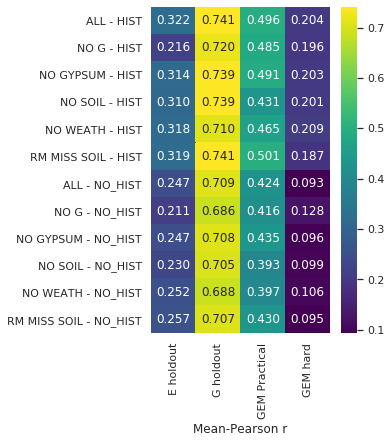

In [32]:
tmp=final_sums_out[final_sums_out["method"].isin(desired_methods)]
table_mean_r = make_table_scenarios_methods(tmp, stat="Pearson r")
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(4,6))
ax = sns.heatmap(table_mean_r[["E holdout", "G holdout", "GEM Practical", "GEM hard"]], annot=True, fmt=".3f", cmap='viridis')
plt.show()

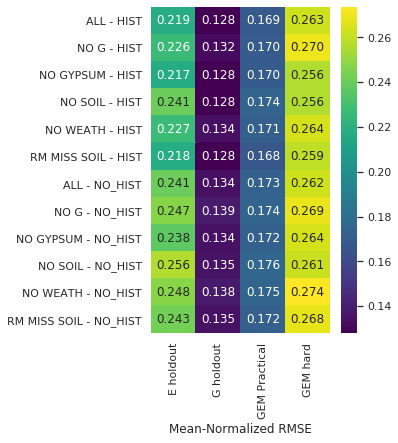

In [31]:
tmp=final_sums_out[final_sums_out["method"].isin(desired_methods)]
table_mean_nRMSE = make_table_scenarios_methods(tmp, stat="Normalized RMSE")
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(4,6))
ax = sns.heatmap(table_mean_nRMSE[["E holdout", "G holdout", "GEM Practical", "GEM hard"]], annot=True, fmt=".3f", cmap='viridis')
plt.show()

In [33]:
#drop some duplicates before printing final data
final_sums_out = final_sums_out[final_sums_out["method"].isin(["GE/GxE BLUP","DE/DxE BLUP",'AUTO CGM','CNN/MLP', "ReluFinalWeathCons"])==False]
final_sums_out = final_sums_out[["method","scenario","Mean/std",'Pearson r',"slope","RMSE",'Relative RMSE','Normalized RMSE',"n_folds"]]
final_sums_out = final_sums_out.sort_values(["Mean/std","scenario","RMSE"]).reset_index(drop=True)
final_sums_out.to_csv("../data/Results/Final_result_summarys_ordered_27July2021.csv")